# Image Captioning Neural Network
An image caption generator needs to be able to generate a concise one-phrase description of an image. That is, it needs to be able to describe the objects in the image, and the context in which those objects exist.

The image captioning neural network defined in the code below is essentially a sequence-to-sequence model, which consists of an encoder and a decoder The encoder in my model uses the ResNext model with pre-trained weights for the ImageNet database, while the decoder is made up of a word embedding layer and an LSTM block.

In [1]:
import torch
from torch.utils.data import Dataset, DataLoader
import torchvision
import torchvision.transforms as transforms
import torchvision.models as models
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.nn.utils.rnn import pad_sequence

import pandas as pd
from PIL import Image

import multiprocessing
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gs

import os
import random
import string
from IPython.display import clear_output
import time

In [2]:
device = torch.device(0 if torch.cuda.is_available() else 'cpu') # Choosing a device to run our network on

In [3]:
train_model = False # Set to False to run inference

### Function to make token dictionary
The funtion defined below takes in all the unique words in the caption file and then constructs a dictionary of words and their corresponding tokens. However, each of the words must occur more than a spesified number of times in the caption file in order for the token dictionary to recrod it. This is done to prevent the model from learning words that are too sepsific.

In [4]:
def make_tokenDict(all_captions, threshold):
    
    unique_words = {} # dictionary to hold all unique words of the caption file 
    tokenDict = {"<PAD>":0, "<SOS>":1, "<EOS>":2, "<UNK>":3} # dictionary that will hold the ultimate token dictionary 
    # initial words already defined above are used in processing the captions while they are being generated and manupilated 
    # as tokens
    
    idx = 4 # starting from index 4 of the dictionary because the the inital indcies have already been defined
    for phrase in all_captions:
        # looping through each caption
        phrase = phrase.translate(str.maketrans('', '', string.punctuation)) # removing punctuation in each caption
        for word in phrase.lower().split():
            # converting each caption to lower case and then splitting each caption to an array of words
            if word not in string.punctuation:
                if word in unique_words:
                    # if a word that already exists is detected then increment the number of occurances of that word
                    unique_words[word] +=1
                else:
                    # if a new word is found add it to the unique words dictionary
                    unique_words[word] = 1
               
                if unique_words[word] > threshold:
                       if word not in tokenDict:
                        # if the current word has a count over the threshold specified and it doesnt already exist in the
                        # token dictionary, then add it with a new token
                        tokenDict[word] = idx
                        idx += 1
    return tokenDict

###  Class used to translate between words and tokens
The class defined below will take in a token dictionary made by the function above and provide methods of translating from words to tokens or from tokens to words based on that dictionary.

In [5]:
class Translator():
    def __init__(self, tokenDict):
        self.tokenDict = tokenDict
        self.wordDict = {} # dictionary used to hold inverted token dictionary 
        self.special = {"<PAD>":0, "<SOS>":1, "<EOS>":2, "<UNK>":3} # special tokens the same as the ones defined above
        
        for idx, word in enumerate(self.tokenDict):
            # this loop inverts the token-to-word dictionary in order to make the word-to-token dictionary
            self.wordDict[idx] = word 
    
    def __len__(self):
        return len(self.wordDict) # the number of words in the dictionary
        
    def w2t(self, inArray):
        # method takes in a phrase and returns an array of tokens corresponding to each word
        inArray = inArray.split() # splitting the input phrase to an array of words
        outArray = [] # vector that will hold output tokens
        for word in inArray:
            # looping through each word in the phrase
            if word not in self.special:
                # if not a special reserved word convert the word into lower case
                word = word.lower()
            if word in self.tokenDict:
                # if the word is recorded in the given token ditionary then append the correct token
                outArray.append(self.tokenDict[word])
            else:
                # if the word does not exist in the given token ditionary then append the token for "<UNK>"
                outArray.append(3)
        return outArray
    
    def t2w(self, inArray):
        # method takes in an array of tokens and returns an array of words corresponding to those tokens
        outArray =[]
        for token in inArray:
            # looping though each token
            if token in self.wordDict:
                # If the token exists in the token-to-word dictionary then append the correct word
                outArray.append(self.wordDict[token])
        return outArray

### Custom datset class
The class defined below is used to acsess the Flickr8k dataset used to train the caption generating model. The images exist as spearate .jpeg files in folder containing images while the captions are found in a .txt file with a column for image file naame and a column corresponding to the caption. Furthermore, each image has 5 corresponding captions.

In [6]:
class FlikrData(Dataset):
    def __init__(self, threshold = 5, transform = None):
        self.img_dir = 'data/images' # directory of images 
        self.text_file = pd.read_csv('data/captions.txt') # reading the captions as a csv file
        self.img_name = self.text_file["image"] # extracting all the image names for each index or row 
        self.img_caption = self.text_file["caption"] # extracting all the images in that correspond to each of the images
        
        # defining a local translator
        self.translate = Translator(make_tokenDict(self.img_caption,threshold))
        
        self.transform = transform
        
    def __len__(self):        
        return len(self.img_caption) # returns the number of indices accessible
    
    def __getitem__(self, idx):
        caption = self.img_caption[idx] # extracting the caption for a sepecified index
        name = self.img_name[idx] # extracting the image name for a spesific index
        img_loc = os.path.join(self.img_dir,name) 
        img = Image.open(img_loc).convert("RGB") # using the image name to import spesified image 
        
        if self.transform is not None:
            # applying specified torch transforms
            img = self.transform(img)
        
        tokens = [1] + self.translate.w2t(caption) + [2] # tokenizing the caption and adding start and end tags
        
        return [img, torch.tensor(tokens)]

The class defined below acts as the collate_fn for the pytorch data loader. It takes a batch of captions, finds the longest caption and then pads the rest of the captions with the token corresponding to "<PAD" to make all captions in the batch the same length

In [7]:
class customCollate():
    def __init__(self, padding):
        self.pad = padding # the padding value that needs to be used
            
    def __call__(self, batch):
        img_batch =[] # list to hold the images for the current batch 
        caption_batch=[] # list to hold captions for the current batch
        for idx in batch:
            # adding each of the images in the batch into the img_batch list with a batch dimension
            img_batch.append(idx[0].unsqueeze(0))
        
        caption_batch = [idx[1] for idx in batch] # adding all the captions of the batch into the caption_batch list 
        img_batch = torch.cat(img_batch, dim =0) # concatinating all the images along the batch dimension
        
        # using the pytorch pad_sequence funtion to pad the batch of captions with the spescified padding value
        caption_batch = pad_sequence(caption_batch, batch_first=False, padding_value=self.pad) 
        
        return img_batch, torch.transpose(caption_batch, 0, 1) # making each row of batch correspond to a caption
    

In [8]:
freq_threshold = 5
sample_loder = FlikrData(threshold = freq_threshold, transform = transforms.ToTensor())
translate = Translator(make_tokenDict(pd.read_csv('data/captions.txt')["caption"], freq_threshold))

In [9]:
def img_plotter(sample, translator):
    image = sample[0].numpy().transpose((1, 2, 0))
    caption = " ".join(translate.t2w(sample[1].tolist())[1:-1])
    plt.imshow(image)
    plt.title(caption)

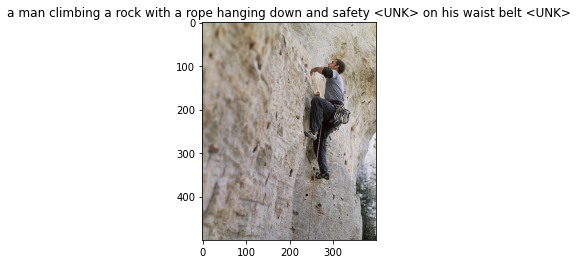

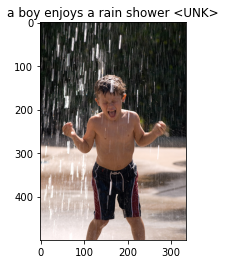

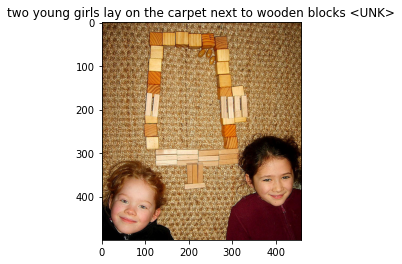

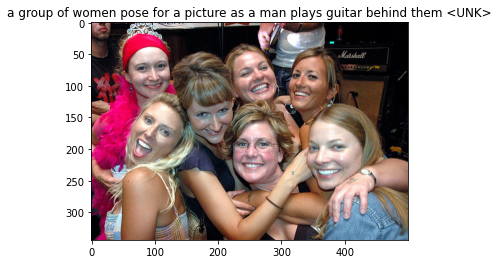

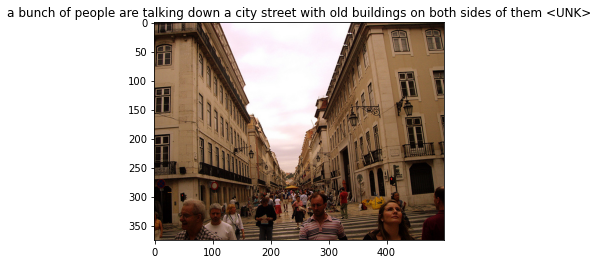

In [10]:
test_idx = np.random.randint(len(sample_loder), size=5)
for tmpC in test_idx:
    img_plotter(sample_loder[tmpC],translate)
    plt.show()

As the dataset only consists of around 8000 images, some data augmentation is appplied to create more training data.

In [11]:
default_transform = transforms.Compose([
    transforms.Resize([255,255]), # resize the image to fit out ResNext model
    transforms.RandomHorizontalFlip(p = 0.5), # flipping the image randomly with a probability of 0.5
    transforms.RandomRotation(15), # rotate the image by a random angle between -15 and 15 degrees
    transforms.ToTensor(), 
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)) # normalize image                     
    ])

In [12]:
freq_threshold = 5 # if a word in the captions folder does not occur more than this many times ignore it 
batch_sz = 4 # defining the batch size

# defining the training data loader with the transformations and the collete function defined above 
train_data = FlikrData(threshold = freq_threshold, transform = default_transform) 
train_loader = DataLoader(dataset=train_data, batch_size=batch_sz, shuffle=True, collate_fn=customCollate(padding=0))

# defining a translation class
translate = Translator(make_tokenDict(pd.read_csv('data/captions.txt')["caption"], freq_threshold))

In [13]:
print("%d words in current dictionary" % len(translate))

2650 words in current dictionary


## Defining model
The cells below define my model which is essentially a sequence-to-sequence coder. This model uses a CNN as the encoder to extract the features of an image, and then sends this feature vector into a the decoder which is an RNN network, which in turn produces a vector of tokens.

### Encoder
The first part of the model is a CNN that uses the "ResNext" pretrained model as it has the highest accuracy of the pretrained models in pytorch. The CNNs weights are frozen, and its last fully connected layer is replaced with a new layer with learnable weights. The CNN acts as the encoder used to extract the features of the image into a vector of length: 256. This vector is then passed into the RNN which acts as the decoder. 


In [14]:
class CNN_Encoder(nn.Module):
    # CNN encoder module used to extract features of the image
    def __init__(self, connection_size = 256):
        super(CNN_Encoder, self).__init__()
        self.CS = connection_size # connection size will be the dimentions of the embedding used to represent vectorized words
        # using the ResNext model with pretrained weights
        self.resnext = models.resnext50_32x4d(pretrained=True)
        # freezing all the weights of the ResNext model
        for param in self.resnext.parameters():
            param.requires_grad = False 
        
        # replacing the last layer of the ResNext model with a trainable fully connected layer
        self.in_ftrs = self.resnext.fc.in_features
        self.resnext.fc = nn.Linear(self.in_ftrs, self.CS)
        
    def forward(self, x):
        return self.resnext(x)

### Decoder
This RNN network uses an embedding layer as wide as the length of the dictionary to cast each word into a vector of default length 256. This is done to develop relationships between each word in the dictionary. Then an LTSM layer is used to predict the logical next word in the sequence. This layer is then passed on to a fully connected layer to produce an array of tokens.

This cell was adapted from https://www.kaggle.com/mdteach/image-captioning-with-out-attention-pytorch

In [15]:
class DecoderRNN(nn.Module):
    def __init__(self,connection_size, hidden_size, dict_size, num_layers=2):
        super(DecoderRNN, self).__init__()
        # defining the embedding layer
        self.embed = nn.Embedding(dict_size,connection_size)
        # defining LTSM layer with stacks of 2 LTSM cells
        self.lstm = nn.LSTM(connection_size,hidden_size,num_layers=num_layers,batch_first=True)
        self.fc1 = nn.Linear(hidden_size, dict_size) #defining fully connected liner layer 
        self.dropout = nn.Dropout(0.5) # dropout layer with a probablity of 0.5
        
    def forward(self, x, cap):
        cap_vect = self.dropout(self.embed(cap)) # passing captions trough embedding
        x = torch.cat((x.unsqueeze(1),cap_vect),dim=1) # concatinate feature vector and the caption in new vector space
        x,_ = self.lstm(x) # pass concatination trough LSTM cell
        x = self.fc1(x)
        return x
    
  

Finally, both the encoder and the decoder are connected together using In the CombineCNN_RNN module.

In [16]:
class CombineCNN_RNN(nn.Module):
    def __init__(self, connection_size, hidden_size, dict_size):
        super(CombineCNN_RNN, self).__init__()
        self.encoder = CNN_Encoder(connection_size).to(device)
        self.decoder = DecoderRNN(connection_size, hidden_size, dict_size).to(device)
    
    def forward(self, x, cap):
        # connecting the output of the encoder to the decoder
        ext = self.encoder(x)
        out = self.decoder(ext, cap)
        return out

### Training Function 
Function iterates though each sample in batch for each epoch though the network defined above 

In [17]:
def training(network, optimizer, dataloader, lossFunc, wordDict, loss):
    network.train() 

    loop_loss = [] # list to hold the loss for each of the images in the current batch 

    for idx, (x, cap) in enumerate(dataloader): 
        x = x.to(device)
        cap = cap.to(device)
        # sending the image and the caption to the network
        # the <EOS> tag is not sent into the network so the network can learn to predict this tag
        net_out = network(x, cap[:,:-1])
        
        # calculating loss by first flattening the output of the network to correspond with the true caption
        curr_loss = lossFunc(net_out.view(-1, len(wordDict)), cap.contiguous().view(-1))  
        
        optimizer.zero_grad()
        curr_loss.backward()
        optimizer.step()
        
        loop_loss.append(int(curr_loss))
          
    loop_loss = np.array(loop_loss).mean()
    loss.append(loop_loss)
    return loss 

Defining hyperparameters, the model, the loss function and the optimizer to be used 

In [18]:
learning_rate = 0.00005
epochs = 50

# defining model
net = CombineCNN_RNN(400,512,len(translate)).to(device)
# defining loss function that will ignore the padding tag
lossFunc = nn.CrossEntropyLoss(ignore_index=translate.w2t("<PAD>")[0])
# defining the optmizer
optimizer = optim.Adam(net.parameters(), lr=learning_rate)


### Loading checkpoints
The cell below was taken from Lab 6 

In [19]:
#Create Save Path from save_dir and model_name, we will save and load our checkpoint here
start_from_checkpoint = True

save_dir = "Saved Models"
model_name = "caption_gen_v4"
Save_Path = os.path.join(save_dir, model_name + ".pt")

#Create the save directory if it does note exist
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)

#Load Checkpoint
if start_from_checkpoint:
    #Check if checkpoint exists
    if os.path.isfile(Save_Path):
        #load Checkpoint
        check_point = torch.load(Save_Path)
        #Checkpoint is saved as a python dictionary
        #https://www.w3schools.com/python/python_dictionaries.asp
        #here we unpack the dictionary to get our previous training states
        net.load_state_dict(check_point['model_state_dict'])
        optimizer.load_state_dict(check_point['optimizer_state_dict'])
        start_epoch = check_point['epoch']
#         best_valid_acc = check_point['valid_acc']
        print("Checkpoint loaded, starting from epoch:", start_epoch)
    else:
        #Raise Error if it does not exist
        raise ValueError("Checkpoint Does not exist")
else:
    #If checkpoint does exist and Start_From_Checkpoint = False
    #Raise an error to prevent accidental overwriting
    if os.path.isfile(Save_Path):
        raise ValueError("Warning Checkpoint exists")
    else:
        print("Starting from scratch")

Checkpoint loaded, starting from epoch: 50


### Training model
Model will be trained if train_model == True

In [20]:
if train_model:
    train_loss = []
    curr_loss = 10 # only used in first loop
    tic = time.perf_counter() # starting timer
    for i in range(epochs):
        clear_output(True)
        
        #print the number of the current epoch and the average loss for the epoch
        print("TRAINING: | Epoch [%d/%d] | Loss %.2f |" %(i+1 ,epochs , curr_loss)) 

        train_loss = training(net, optimizer, train_loader, lossFunc, translate, train_loss)
        curr_loss = train_loss[-1]
        
        # saving check points
        torch.save({
              'epoch':                 i,
              'model_state_dict':      net.state_dict(),
              'optimizer_state_dict':  optimizer.state_dict(), 
              'loss':                  train_loss[-1]
          }, Save_Path)
        
        with open("/Saved Models/loss_V3.txt", "a") as output:
            output.write("\n"+str(train_loss[-1]))

    toc = time.perf_counter() # stopping timer

    

### Function used for inference 
The function below can be used to check how the model performs after training

Adapted from https://www.kaggle.com/mdteach/image-captioning-with-out-attention-pytorch

In [21]:
def predCaption(net, image, max_len, translate):
    # function takes in an image a max length for the predictied caption and a translator class and returns a predicted caption
    net.eval() # run model in evaluation mode
    with torch.no_grad(): # do not build gradient graph 
        x = net.encoder(image).unsqueeze(0) # pass image through encoder CNN
        config = None # inital cell states
        outcap = [] # list to hold predicted caption
        
        for idx in range(max_len):
            # loop for the max number of words specified or untill the "<EOS>" tag is predicted 
            hidden, config = net.decoder.lstm(x, config) # enter feature vector into LSTM 
            out = net.decoder.fc1(hidden.squeeze()).argmax() # get output word with highest probability
            outcap.append(out.item()) # append to the caption list 
            x = net.decoder.embed(out.unsqueeze(0)).unsqueeze(0) # pass the output array of the LTSM into the embedding layer
            # then pass the output of the embedding layer back into the LSTM block to get the net most likely word in the 
            # sequence 
            if out == translate.w2t("<EOS>")[0]: # break out of loop if end of sentence tag is predicted 
                break           
    return translate.t2w(outcap)


## Demonstation of model

In [22]:
demo_transform = transforms.Compose([
    transforms.Resize([255,255]),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
    ])

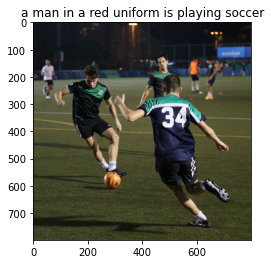

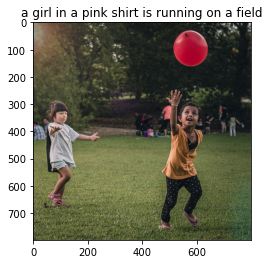

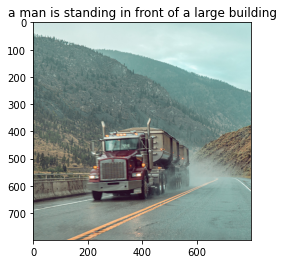

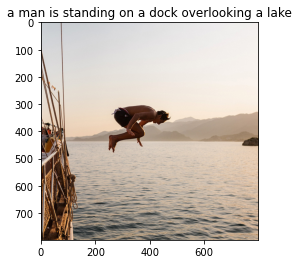

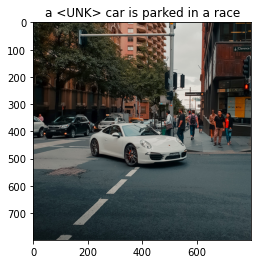

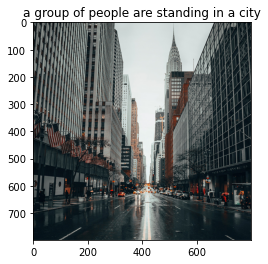

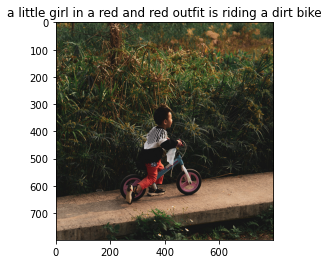

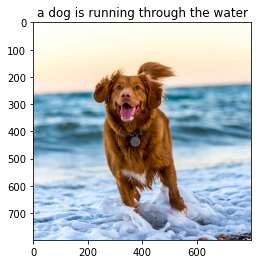

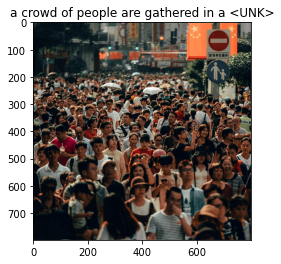

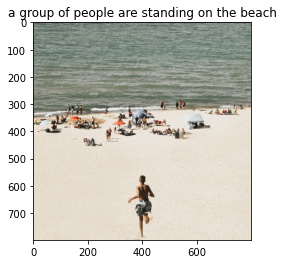

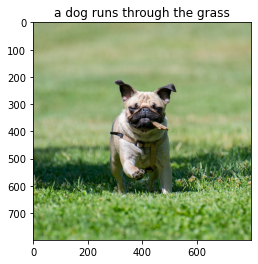

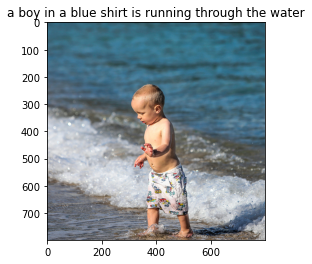

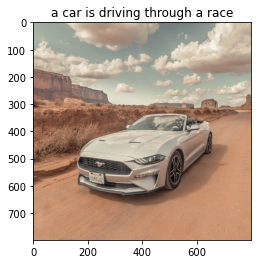

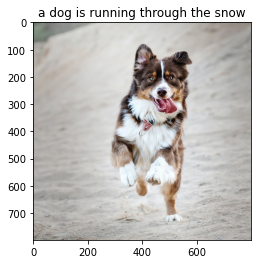

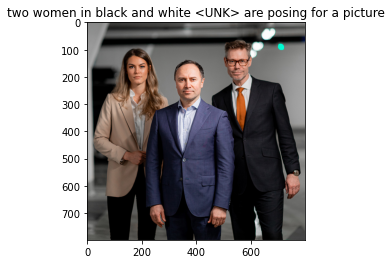

In [23]:
for i in range(15):
    demo_loc = "demo images/"+ str(i+1) + ".jpg"
    img = Image.open(demo_loc).convert("RGB")

    pred_img = demo_transform(img)
    pred_img = pred_img.unsqueeze(0).to(device)
    pred_cap = predCaption(net,pred_img,50,translate)[1:-2]
    plt.imshow(img)
    plt.title(" ".join(pred_cap))
    plt.show()